# Домашняя работа
### Тема: Модели авторегрессии условной гетероскедантичности

Выберите ряд из первого задания и постройте его модель GARCH.

In [1]:
!pip install arch

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from arch import arch_model
%matplotlib inline

In [3]:
#убираем все варнинги
import warnings
warnings.filterwarnings('ignore')

In [4]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv")

In [5]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


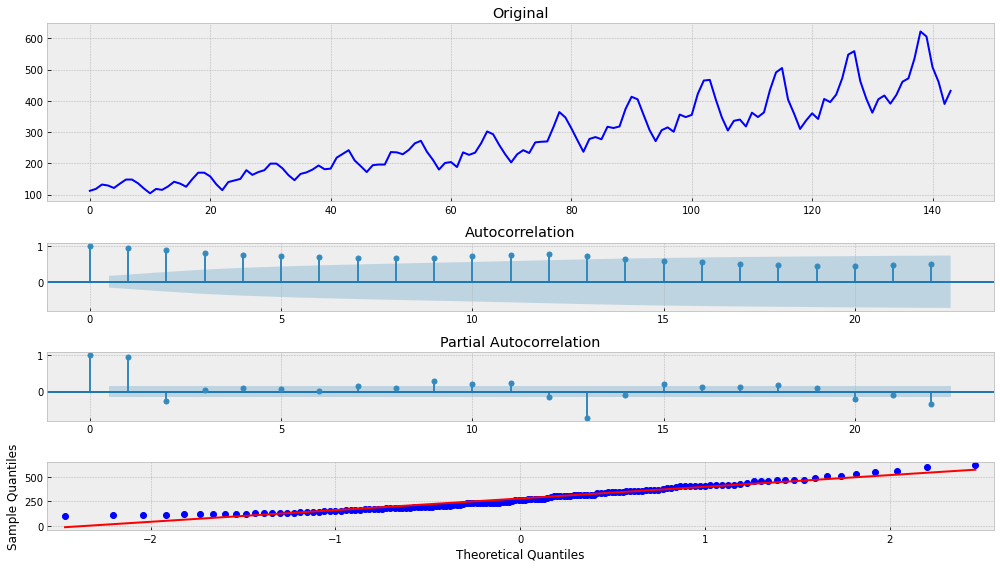

In [8]:
tsplot(airlines_passengers["Count"])

**Делаем стационарным ряд**

Results of Dickey-Fuller Test:
Test Statistic                -1.638423e+01
p-value                        2.732892e-29
#Lags Used                     1.100000e+01
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


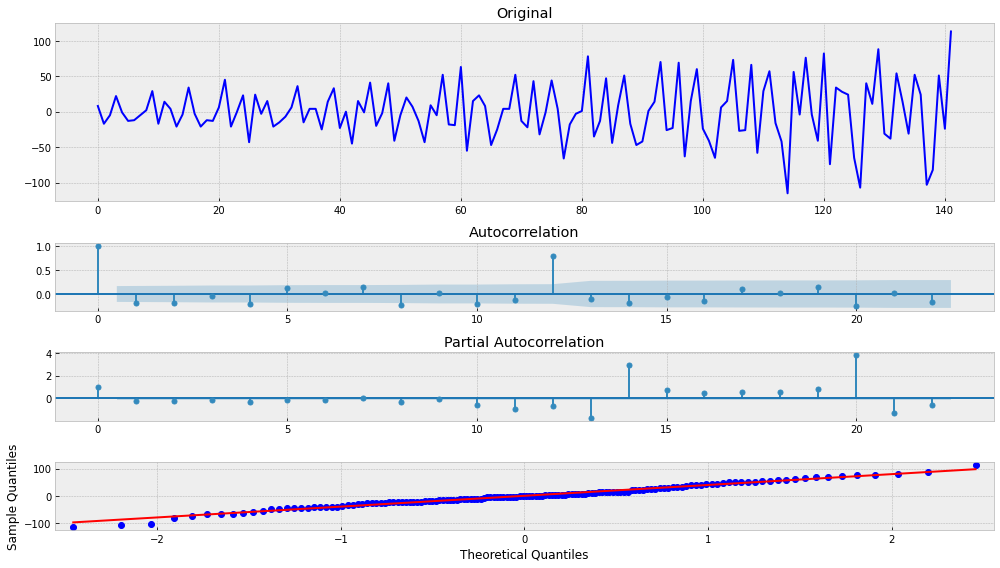

In [9]:
series = difference(airlines_passengers["Count"])
series = difference(series, 1)
tsplot(series)

In [10]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [11]:
aic, order, mdl = _get_best_model(series)

aic: 1345.28769 | order: (4, 0, 4)


Results of Dickey-Fuller Test:
Test Statistic                  -2.220187
p-value                          0.199000
#Lags Used                      14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


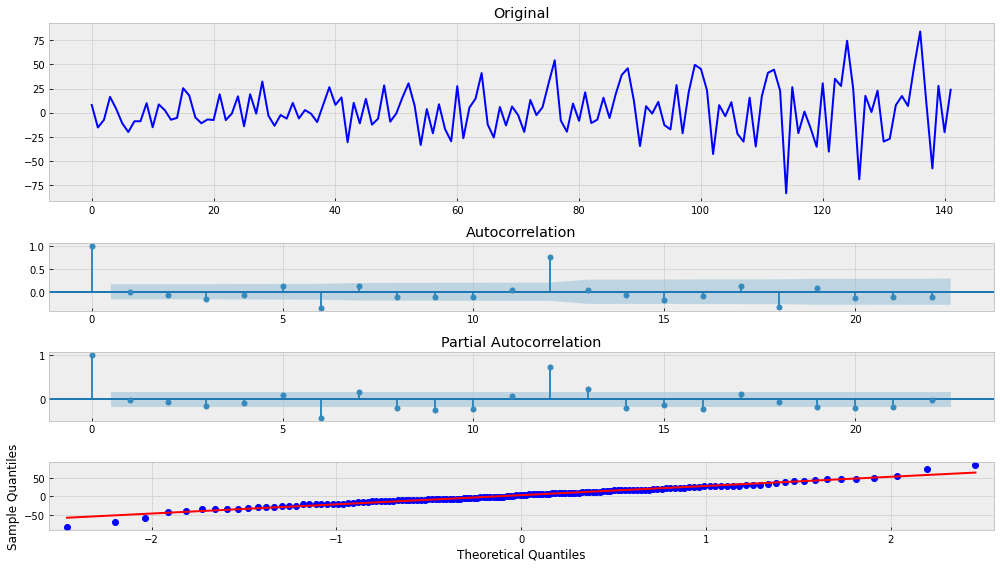

In [12]:
tsplot(mdl.resid)

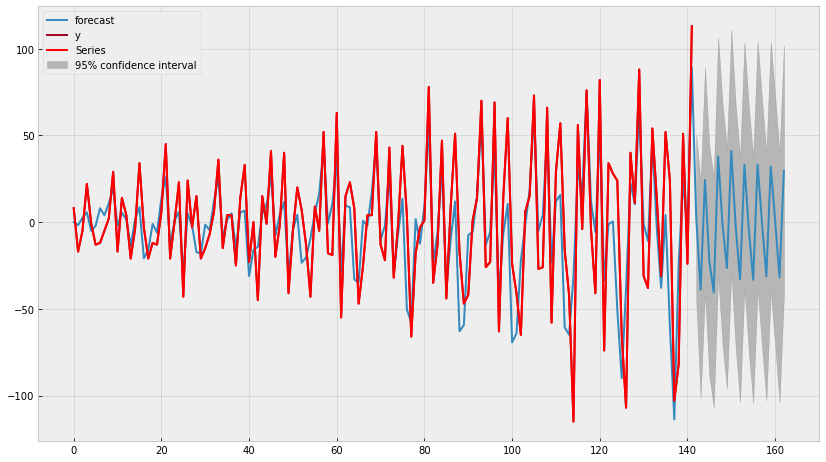

In [13]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [14]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     63,   Neg. LLF: 699.893257208683
Iteration:     10,   Func. Count:    123,   Neg. LLF: 699.1195229012135
Iteration:     15,   Func. Count:    183,   Neg. LLF: 698.2692586775231
Iteration:     20,   Func. Count:    243,   Neg. LLF: 697.9939712303319
Iteration:     25,   Func. Count:    325,   Neg. LLF: 697.9844210853017
Iteration:     30,   Func. Count:    388,   Neg. LLF: 697.9824213242018
Iteration:     35,   Func. Count:    448,   Neg. LLF: 697.9432237793135
Iteration:     40,   Func. Count:    512,   Neg. LLF: 697.9180069780857
Optimization terminated successfully    (Exit mode 0)
            Current function value: 697.9057262121088
            Iterations: 44
            Function evaluations: 550
            Gradient evaluations: 43
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -0.001
Mean Model:                   Constant Mean  

Results of Dickey-Fuller Test:
Test Statistic                -1.638423e+01
p-value                        2.732892e-29
#Lags Used                     1.100000e+01
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


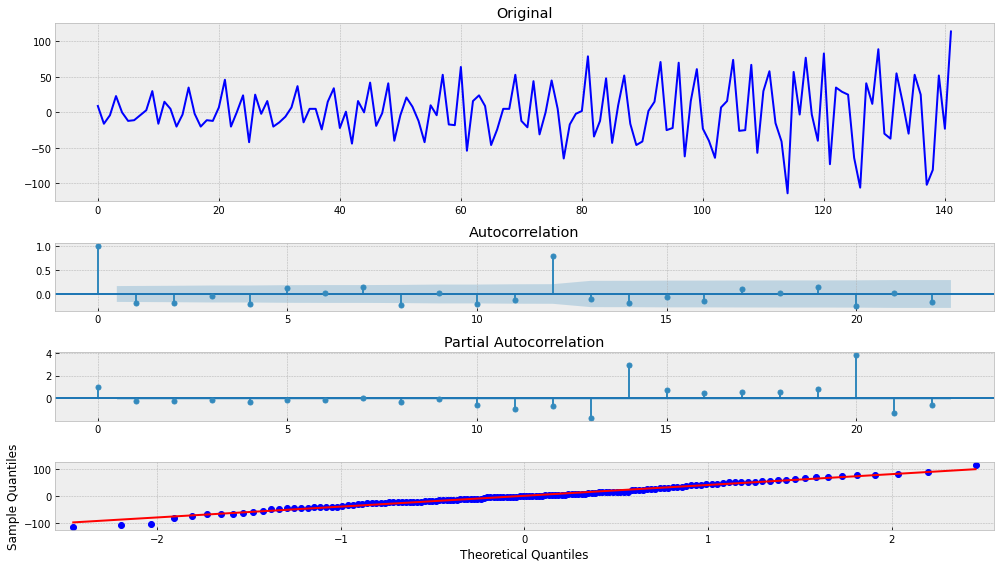

In [15]:
tsplot(res.resid)